In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Normalize the MNIST dataset using precomputed mean and standard deviation.
# These values help improve training stability and convergence speed by ensuring that the pixel values
# are centered around 0 and have a standard deviation of 1.

# Precomputed values for the MNIST dataset:
#   - Mean (μ) = 0.1307
#   - Standard Deviation (σ) = 0.3081

In [281]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [317]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):               # B -> Batch Size
        x = self.relu(self.conv1(x))    # find simple patterns -> (B, 32, 28, 28)
        x = self.relu(self.conv2(x))    # build more complex patterns -> (B, 64, 28, 28)
        x = self.pool(x)                # down‑sample, keep strongest signals  -> (B, 64, 14, 14)
        x = x.view(x.size(0), -1)       # flatten to a vector -> (B, 12544)
        x = self.relu(self.fc1(x))      # mix into 128 features -> (B, 128)
        x = self.fc2(x)                 # final 10 class scores -> (B, 10)
        return x

In [310]:

def train(model, train_loader, test_loader, device, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)  # reduce LR by a factor of 0.5 every epochs, allows big steps then finer tuning


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.4f}")

        epoch_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1} - Training Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

        scheduler.step()

    torch.save(model.state_dict(), "model.pth")


In [318]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel().to(device)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

train(model, train_loader, test_loader, device, epochs=5)

Epoch 1, Batch 100, Loss: 0.1962
Epoch 1, Batch 200, Loss: 0.0523
Epoch 1, Batch 300, Loss: 0.0316
Epoch 1, Batch 400, Loss: 0.0727
Epoch 1 - Training Loss: 0.1342, Accuracy: 95.84%
Epoch 2, Batch 100, Loss: 0.0419
Epoch 2, Batch 200, Loss: 0.0960
Epoch 2, Batch 300, Loss: 0.0051
Epoch 2, Batch 400, Loss: 0.0114
Epoch 2 - Training Loss: 0.0302, Accuracy: 99.09%
Epoch 3, Batch 100, Loss: 0.0371
Epoch 3, Batch 200, Loss: 0.0112
Epoch 3, Batch 300, Loss: 0.0018
Epoch 3, Batch 400, Loss: 0.0082
Epoch 3 - Training Loss: 0.0162, Accuracy: 99.54%
Epoch 4, Batch 100, Loss: 0.0020
Epoch 4, Batch 200, Loss: 0.0042
Epoch 4, Batch 300, Loss: 0.0065
Epoch 4, Batch 400, Loss: 0.0004
Epoch 4 - Training Loss: 0.0093, Accuracy: 99.77%
Epoch 5, Batch 100, Loss: 0.0136
Epoch 5, Batch 200, Loss: 0.0066
Epoch 5, Batch 300, Loss: 0.0013
Epoch 5, Batch 400, Loss: 0.0029
Epoch 5 - Training Loss: 0.0066, Accuracy: 99.87%


#Model Evaluation

In [319]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)#fwd


            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")


In [320]:

evaluate(model, test_loader, device)

Test Accuracy: 99.08%


#Demo Testing

In [ ]:
!pip install ipywidgets
!pip install ipycanvas


In [342]:
import torch
import numpy as np
import ipywidgets as widgets
from ipycanvas import Canvas
from PIL import Image
from spikingjelly.activation_based import functional
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [506]:
def start_drawing(x, y):
    global drawing
    drawing = True
    canvas.stroke_style = 'white'
    canvas.line_width = 20
    canvas.begin_path()
    canvas.move_to(x, y)

def draw(x, y):
    if drawing:
        canvas.line_to(x, y)
        canvas.stroke()

def stop_drawing(x, y):
    global drawing
    drawing = False
    predict_drawing()


In [487]:
def process_drawing(image):
    img = np.array(image)
    # to fit input params, image is 512x512, need to put into 28x28
    img = Image.fromarray((img).astype(np.uint8)).resize((28, 28))
    img = np.array(img)
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 28, 28]
    return img

def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model, device

def predict_drawing():
    model_path = 'model.pth'
    model, device = load_model(model_path)

    img_data = canvas.get_image_data(0, 0, 512, 512)
    img_pil = Image.fromarray(img_data).convert('L')
    img_np = np.array(img_pil)

    img = process_drawing(img_np)  #  [1, 1, 28, 28] normalized
    img = img.to(device)

    model.eval()
    with torch.no_grad():
        output = model(img)
        probabilities = torch.softmax(output, dim=1)
        predicted_digit = torch.argmax(probabilities, dim=1).item()

    print("Probabilities:", probabilities.cpu().numpy())
    print(f"Predicted digit: {predicted_digit}")

    img_display = img.squeeze().cpu().numpy()
    plt.imshow(img_display, cmap='gray')
    plt.title(f"Predicted: {predicted_digit}")
    plt.axis('off')
    plt.show()


Canvas(height=512, sync_image_data=True, width=512)

Probabilities: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted digit: 5


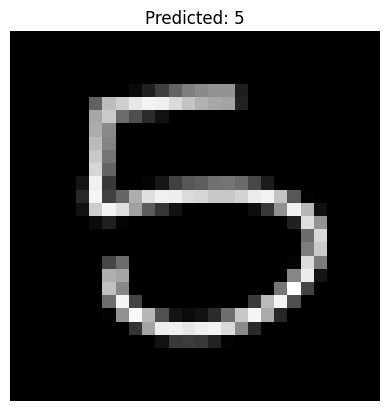

In [517]:
from IPython.display import display

canvas = Canvas(width=512, height=512, sync_image_data=True)
canvas.fill_style = 'black'
canvas.fill_rect(0, 0, canvas.width, canvas.height)

# display the canvas in Colab
display(canvas)
canvas.on_mouse_move(draw)
canvas.on_mouse_up(stop_drawing)
canvas.on_mouse_down(start_drawing)


Support for third party widgets will remain active for the duration of the session. To disable support: